<a href="https://colab.research.google.com/github/sun9huni/first-repository/blob/main/0619_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 단어장 개수별 ML 모델 성능 비교 (Accuracy / F1-score)

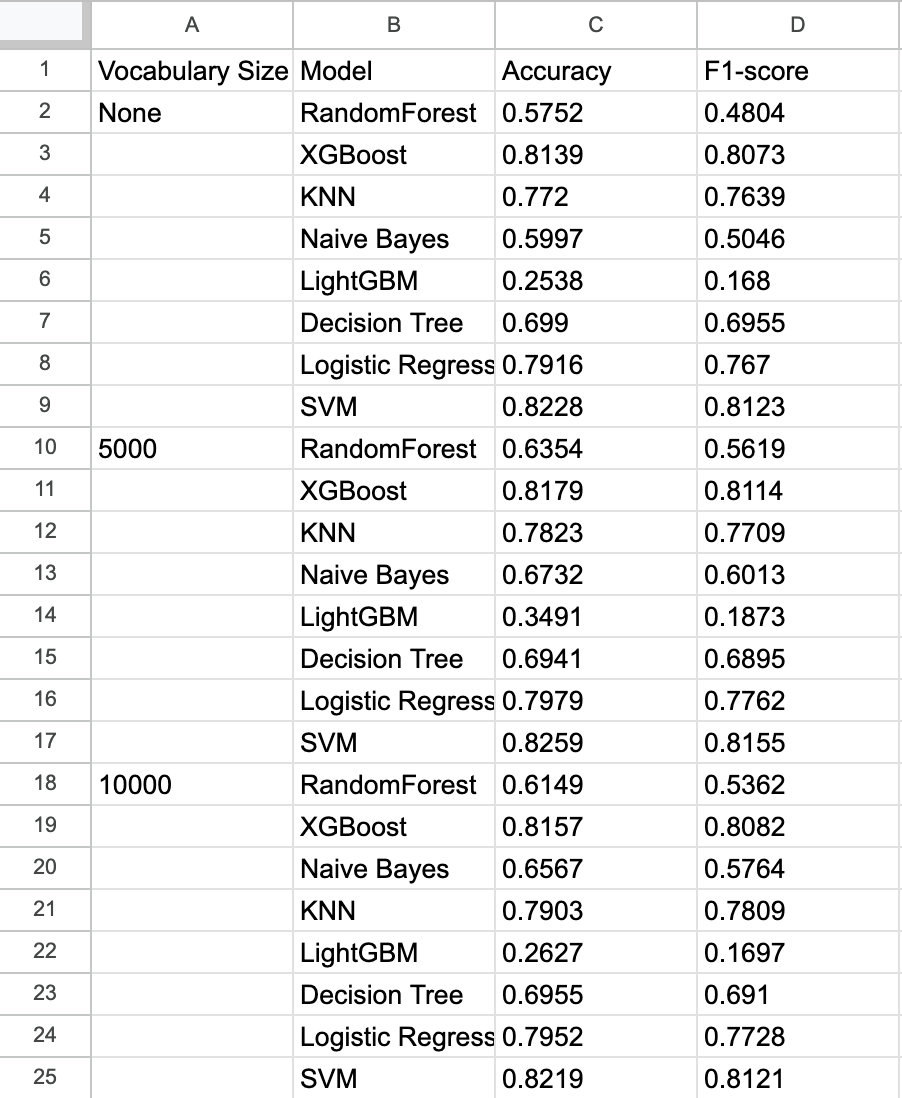

- vocab= [10000] 모델은 다른 플랫폼에서 구동
- 제일 좋은 모델은 Vocaburaly Size = 10000, SVM 모델이 Accuracy 0.8259, F1-score 0.8155로 가장 성능이 좋았다.


# 벡터화 방법별 ML/DL 모델 성능 비교 (Accuracy / F1-score)


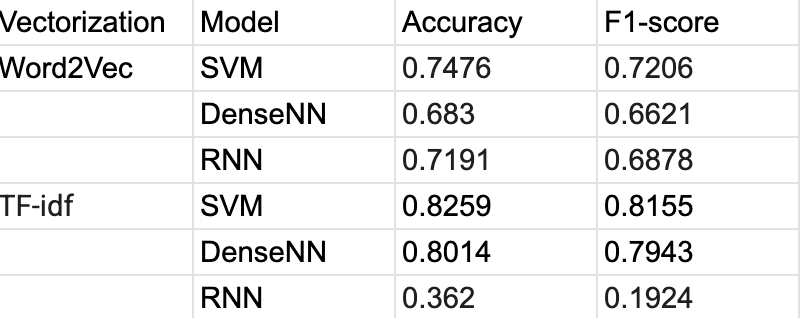

- 성능이 가장 좋았던 SVM과 딥러닝인 DenseNN, RNN을 비교했다.
- Word2Vec 벡터화로 시행시 SVM이 가장 높은 성능이 나왔다.
- TF-idf의 경우도 SVM이 가장 높은 성능이 나왔다.


In [3]:
!pip install gensim

In [4]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [4]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [5]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [6]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [7]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [8]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [9]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely <unk> borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in <unk> financial eligibility standards indicated as many as one half of <unk> borrowers who received new loans from the agency in 1986 would be <unk> under the proposed system the agency has proposed evaluating <unk> credit using a variety of financial ratios instead of relying solely on <unk> ability senate agriculture committee chairman patrick leahy d vt <unk> the proposed eligibility changes telling <unk> administrator <unk> clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' lender of last re

In [10]:
# 벡터화 W2V방법
from gensim.models import Word2Vec

# 우선 문장을 토큰화 시킵시다 띄어쓰기 기반으로 해볼게요! -> # 위에서 DTM만들때는 왜 안해줬냐! -> CountVectorizer에서 띄어쓰기 기반 토큰화가 내장되있음
x_train_tokenized = [sentence.split() for sentence in x_train]
x_test_tokenized = [sentence.split() for sentence in x_test]

model = Word2Vec(sentences = x_train_tokenized, vector_size = 256, window = 5, min_count = 5, workers = 4, sg = 0)
print("모델 학습 완료!")

모델 학습 완료!


In [11]:
# W2V이 잘되었는지 확인 -> 여차저차 되긴한것같다
model_result = model.wv.most_similar('man')
print(model_result)

[('erbynn', 0.8217394948005676), ('row', 0.8208158612251282), ('tape', 0.8096169829368591), ('acting', 0.8082320094108582), ('read', 0.8033486008644104), ('expert', 0.8005827069282532), ('gaming', 0.7981208562850952), ('kobena', 0.7951277494430542), ('olivetti', 0.7944216728210449), ('disputed', 0.7929996252059937)]


In [12]:
# 학습된 Word2Vec 모델
w2v_model = model

# 각 문장을 벡터화 시키는 코드
def vectorize_sentence(sentence, model, max_len):
    vecs = []
    for word in sentence:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            vecs.append(np.zeros(model.vector_size))
    # Padding
    if len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))
    else:
        vecs = vecs[:max_len]
    return np.array(vecs)


# 최대 문장길이를 잘 잡아주세요
x_train_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_train_tokenized])
x_test_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_test_tokenized])



In [13]:
x_train_w2v.shape

(8982, 100, 256)

In [14]:
x_test_w2v.shape

(2246, 100, 256)

In [15]:
# TF-idf데이터로 XGBoost 모델 학습하기

from xgboost import XGBClassifier

# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
# 예측
y_pred = xgb_model.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7930
✅ F1-score : 0.7856


In [18]:
# 데이터를 단어단위에서 문장단위로 바꿔줘야합니다.. ML은 2차원데이터만 받을수있기때문
# 문장에 대해서 토큰들의 벡터를 평균을 취해줍니다.

# Word2Vec 임베딩 시퀀스: (8982, 100, 256)
x_w2v_seq_train = x_train_w2v
x_w2v_seq_test = x_test_w2v
# 평균 풀링 → (8982, 256)
x_w2v_avg_train = np.mean(x_w2v_seq_train, axis=1)
x_w2v_avg_test = np.mean(x_w2v_seq_test, axis=1)
print(x_w2v_avg_train.shape)  # (8982, 256)

(8982, 256)


In [19]:
# Word2Vec 데이터로 XGBoost 모델 학습하기
from xgboost import XGBClassifier


# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_w2v_avg_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
# 예측
y_pred = xgb_model.predict(x_w2v_avg_test)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7297
✅ F1-score : 0.7115


## vocab_sizes = [None] 모델 구동
- 'Logistic Regression', 'SVM', 'RandomForest', 'XGBoost', 'Naive Bayes', 'KNN', 'LightGBM', 'Decision Tree'

In [12]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Define vocabulary sizes and models
vocab_sizes = [None]
models = ['Logistic Regression', 'SVM', 'RandomForest', 'XGBoost', 'Naive Bayes', 'KNN', 'LightGBM', 'Decision Tree']

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Vocabulary Size', 'Model', 'Accuracy', 'F1-score'])

for vocab_size in vocab_sizes:
    print(f"Processing with vocabulary size: {vocab_size}")

    # 1. Load the Reuters dataset
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

    # 2. Get the word index
    word_index = reuters.get_word_index(path="reuters_word_index.json")

    # 3. Create a dictionary index_to_word
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
      index_to_word[index]=token

    # 4. Decode the training and testing data
    decoded_train = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(t)
    x_train_decoded = decoded_train

    decoded_test = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(t)
    x_test_decoded = decoded_test

    # 5. Initialize a CountVectorizer and fit it to the training data
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train_decoded)

    # 6. Transform both the training and testing data
    x_test_dtm = dtmvector.transform(x_test_decoded)

    # 7. Initialize a TfidfTransformer and fit it to the count-vectorized training data
    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)

    # 8. Transform both the count-vectorized training and testing data
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

    print("TF-IDF vectorization completed.")
    print(f"Shape of x_train_tfidf: {x_train_tfidf.shape}")
    print(f"Shape of x_test_tfidf: {x_test_tfidf.shape}")

    # The inner loop for models will be handled in subsequent cells

Processing with vocabulary size: 5000
TF-IDF vectorization completed.
Shape of x_train_tfidf: (8982, 4867)
Shape of x_test_tfidf: (2246, 4867)


In [3]:
model_name = 'RandomForest'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    # Reduced estimators, limited depth, increased min_samples_split
    model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, n_jobs=-1)
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: RandomForest
    Accuracy: 0.5752
    F1-score: 0.4804


/tmp/ipython-input-3-1187686989.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405


In [4]:
model_name = 'XGBoost'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    # Adjusted hyperparameters for faster training
    model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='mlogloss', use_label_encoder=False)
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:15:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    Accuracy: 0.8139
    F1-score: 0.8073


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254


In [5]:
model_name = 'Naive Bayes'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: Naive Bayes
    Accuracy: 0.5997
    F1-score: 0.5046


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254
2,None,Naive Bayes,0.599733,0.504567


In [6]:
model_name = 'KNN'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: KNN
    Accuracy: 0.7720
    F1-score: 0.7639


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254
2,None,Naive Bayes,0.599733,0.504567
3,None,KNN,0.772039,0.763933


In [7]:
model_name = 'LightGBM'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.547910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163329
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 3971
[LightGBM] [Info] Start training from score -5.095645
[LightGBM] [Info] Start training from score -3.034552
[LightGBM] [Info] Start training from score -4.798913
[LightGBM] [Info] Start training from score -1.044967
[LightGBM] [Info] Start training from score -1.527906
[LightGBM] [Info] Start training from score -6.269765
[LightGBM] [Info] Start training from score -5.231777
[LightGBM] [Info] Start training from score -6.330389
[LightGBM] [Info] Start training from score -4.168504
[LightGBM] [Info] Start training from score -4.487857
[LightGBM] [Info] Start training from score -4.282696
[LightGBM] [Info] Start training from score -3.136

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    Accuracy: 0.2538
    F1-score: 0.1680


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254
2,None,Naive Bayes,0.599733,0.504567
3,None,KNN,0.772039,0.763933
4,None,LightGBM,0.253785,0.167963


In [8]:
model_name = 'Decision Tree'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: Decision Tree
    Accuracy: 0.6990
    F1-score: 0.6955


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254
2,None,Naive Bayes,0.599733,0.504567
3,None,KNN,0.772039,0.763933
4,None,LightGBM,0.253785,0.167963
5,None,Decision Tree,0.699020,0.695454


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [9]:
model_name = 'Logistic Regression'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: Logistic Regression
    Accuracy: 0.7916
    F1-score: 0.7670


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254
2,None,Naive Bayes,0.599733,0.504567
3,None,KNN,0.772039,0.763933
4,None,LightGBM,0.253785,0.167963
5,None,Decision Tree,0.699020,0.695454
6,None,Logistic Regression,0.791630,0.767021


In [10]:
model_name = 'SVM'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True, kernel='linear')
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: SVM
    Accuracy: 0.8228
    F1-score: 0.8123


,Vocabulary Size,Model,Accuracy,F1-score
0,None,RandomForest,0.575245,0.480405
1,None,XGBoost,0.813891,0.807254
2,None,Naive Bayes,0.599733,0.504567
3,None,KNN,0.772039,0.763933
4,None,LightGBM,0.253785,0.167963
5,None,Decision Tree,0.699020,0.695454
6,None,Logistic Regression,0.791630,0.767021
7,None,SVM,0.822796,0.812282


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## vocab_sizes = [5000] 모델 구동
- 'Logistic Regression', 'SVM', 'RandomForest', 'XGBoost', 'Naive Bayes', 'KNN', 'LightGBM', 'Decision Tree'



In [ ]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Define vocabulary sizes and models
vocab_sizes = [5000]
models = ['Logistic Regression', 'SVM', 'RandomForest', 'XGBoost', 'Naive Bayes', 'KNN', 'LightGBM', 'Decision Tree']

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Vocabulary Size', 'Model', 'Accuracy', 'F1-score'])

for vocab_size in vocab_sizes:
    print(f"Processing with vocabulary size: {vocab_size}")

    # 1. Load the Reuters dataset
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

    # 2. Get the word index
    word_index = reuters.get_word_index(path="reuters_word_index.json")

    # 3. Create a dictionary index_to_word
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
      index_to_word[index]=token

    # 4. Decode the training and testing data
    decoded_train = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(t)
    x_train_decoded = decoded_train

    decoded_test = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(t)
    x_test_decoded = decoded_test

    # 5. Initialize a CountVectorizer and fit it to the training data
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train_decoded)

    # 6. Transform both the training and testing data
    x_test_dtm = dtmvector.transform(x_test_decoded)

    # 7. Initialize a TfidfTransformer and fit it to the count-vectorized training data
    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)

    # 8. Transform both the count-vectorized training and testing data
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

    print("TF-IDF vectorization completed.")
    print(f"Shape of x_train_tfidf: {x_train_tfidf.shape}")
    print(f"Shape of x_test_tfidf: {x_test_tfidf.shape}")

    # The inner loop for models will be handled in subsequent cells

Processing with vocabulary size: 5000
TF-IDF vectorization completed.
Shape of x_train_tfidf: (8982, 4867)
Shape of x_test_tfidf: (2246, 4867)


In [13]:
model_name = 'RandomForest'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    # Reduced estimators, limited depth, increased min_samples_split
    model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, n_jobs=-1)
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: RandomForest
    Accuracy: 0.6354
    F1-score: 0.5619


/tmp/ipython-input-13-1187686989.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895


In [14]:
model_name = 'XGBoost'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    # Adjusted hyperparameters for faster training
    model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='mlogloss', use_label_encoder=False)
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    Accuracy: 0.8179
    F1-score: 0.8114


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360


In [16]:
model_name = 'Naive Bayes'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: Naive Bayes
    Accuracy: 0.6732
    F1-score: 0.6013


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360
2,5000,KNN,0.782280,0.770920
3,5000,Naive Bayes,0.673197,0.601250


In [17]:
model_name = 'KNN'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: KNN
    Accuracy: 0.7823
    F1-score: 0.7709


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360
2,5000,KNN,0.782280,0.770920
3,5000,Naive Bayes,0.673197,0.601250
4,5000,KNN,0.782280,0.770920


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['F1-score'].plot(kind='hist', bins=20, title='F1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Accuracy', y='F1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1-score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1-score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['F1-score'].plot(kind='line', figsize=(8, 4), title='F1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='F1-score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [18]:
model_name = 'LightGBM'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163231
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 3957
[LightGBM] [Info] Start training from score -5.095645
[LightGBM] [Info] Start training from score -3.034552
[LightGBM] [Info] Start training from score -4.798913
[LightGBM] [Info] Start training from score -1.044967
[LightGBM] [Info] Start training from score -1.527906
[LightGBM] [Info] Start training from score -6.269765
[LightGBM] [Info] Start training from score -5.231777
[LightGBM] [Info] Start training from score -6.330389
[LightGBM] [Info] Start training from score -4.168504
[LightGBM] [Info] Start training from score -4.487857
[LightGBM] [Info] Start training from score -4.282696
[LightGBM] [Info] Start training from score -3.136

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    Accuracy: 0.3491
    F1-score: 0.1873


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360
2,5000,KNN,0.782280,0.770920
3,5000,Naive Bayes,0.673197,0.601250
4,5000,KNN,0.782280,0.770920
5,5000,LightGBM,0.349065,0.187320


In [19]:
model_name = 'Decision Tree'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: Decision Tree
    Accuracy: 0.6941
    F1-score: 0.6895


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360
2,5000,KNN,0.782280,0.770920
3,5000,Naive Bayes,0.673197,0.601250
4,5000,KNN,0.782280,0.770920
5,5000,LightGBM,0.349065,0.187320
6,5000,Decision Tree,0.694123,0.689481


In [20]:
model_name = 'Logistic Regression'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True)
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: Logistic Regression
    Accuracy: 0.7979
    F1-score: 0.7762


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360
2,5000,KNN,0.782280,0.770920
3,5000,Naive Bayes,0.673197,0.601250
4,5000,KNN,0.782280,0.770920
5,5000,LightGBM,0.349065,0.187320
6,5000,Decision Tree,0.694123,0.689481
7,5000,Logistic Regression,0.797863,0.776227


In [21]:
model_name = 'SVM'
print(f"  Training and evaluating: {model_name}")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=500)
elif model_name == 'SVM':
    model = SVC(probability=True, kernel='linear')
elif model_name == 'RandomForest':
    model = RandomForestClassifier()
elif model_name == 'XGBoost':
    model = XGBClassifier(eval_metric='mlogloss')
elif model_name == 'Naive Bayes':
    model = MultinomialNB()
elif model_name == 'KNN':
    model = KNeighborsClassifier()
elif model_name == 'LightGBM':
    model = LGBMClassifier()
elif model_name == 'Decision Tree':
    model = DecisionTreeClassifier()
else:
    model = None
    print(f"  Unknown model: {model_name}")

if model is not None:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1-score: {f1:.4f}")

    new_row = {
        'Vocabulary Size': vocab_size,
        'Model': model_name,
        'Accuracy': acc,
        'F1-score': f1
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

display(results_df)

  Training and evaluating: SVM
    Accuracy: 0.8259
    F1-score: 0.8155


,Vocabulary Size,Model,Accuracy,F1-score
0,5000,RandomForest,0.635352,0.561895
1,5000,XGBoost,0.817898,0.811360
2,5000,KNN,0.782280,0.770920
3,5000,Naive Bayes,0.673197,0.601250
4,5000,KNN,0.782280,0.770920
5,5000,LightGBM,0.349065,0.187320
6,5000,Decision Tree,0.694123,0.689481
7,5000,Logistic Regression,0.797863,0.776227
8,5000,SVM,0.825913,0.815529


from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['F1-score'].plot(kind='hist', bins=20, title='F1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_18.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='Accuracy', y='F1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1-score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1-score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_24['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['F1-score'].plot(kind='line', figsize=(8, 4), title='F1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='F1-score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 벡터화 방법별 ML/DL 모델 성능 비교 (Accuracy / F1-score)

In [5]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [7]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [8]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [9]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


###벡터화 W2V방법

In [7]:
from gensim.models import Word2Vec

x_train_tokenized = [sentence.split() for sentence in x_train]
x_test_tokenized = [sentence.split() for sentence in x_test]

model = Word2Vec(sentences = x_train_tokenized, vector_size = 256, window = 5, min_count = 5, workers = 4, sg = 0)
print("모델 학습 완료!")

모델 학습 완료!


In [8]:
# W2V이 잘되었는지 확인 -> 여차저차 되긴한것같다
model_result = model.wv.most_similar('man')
print(model_result)

[('farms', 0.7959721684455872), ('disputed', 0.7917664647102356), ('simon', 0.7867733836174011), ('jordan', 0.767234206199646), ('site', 0.7559862732887268), ('iowa', 0.7505859732627869), ('ontario', 0.7498706579208374), ('zaire', 0.7496886849403381), ('unions', 0.7491836547851562), ('inspection', 0.7456032633781433)]


In [9]:
# 학습된 Word2Vec 모델
w2v_model = model

# 각 문장을 벡터화 시키는 코드
def vectorize_sentence(sentence, model, max_len):
    vecs = []
    for word in sentence:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            vecs.append(np.zeros(model.vector_size))
    # Padding
    if len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))
    else:
        vecs = vecs[:max_len]
    return np.array(vecs)


# 최대 문장길이를 잘 잡아주세요
x_train_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_train_tokenized])
x_test_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_test_tokenized])


In [11]:
# 데이터를 단어단위에서 문장단위로 바꿔줘야합니다.. ML은 2차원데이터만 받을수있기때문
# 문장에 대해서 토큰들의 벡터를 평균을 취해줍니다.

# Word2Vec 임베딩 시퀀스: (8982, 100, 256)
x_w2v_seq_train = x_train_w2v
x_w2v_seq_test = x_test_w2v
# 평균 풀링 → (8982, 256)
x_w2v_avg_train = np.mean(x_w2v_seq_train, axis=1)
x_w2v_avg_test = np.mean(x_w2v_seq_test, axis=1)
print(x_w2v_avg_train.shape)  # (8982, 256)

(8982, 256)


In [12]:
# Word2Vec 데이터로 SVC 모델 학습하기
from sklearn.svm import SVC


# SVC 모델 학습
SVC_model = SVC(probability=True, kernel='linear')
SVC_model.fit(x_w2v_avg_train, y_train)

SVC(kernel='linear', probability=True)

In [14]:
# 예측
y_pred = SVC_model.predict(x_w2v_avg_test)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7476
✅ F1-score : 0.7206


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


dense_model = Sequential([
    Flatten(input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요!
])

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,179,310 (50.28 MB)

 Trainable params: 13,179,310 (50.28 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
dense_model.fit(x_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5443 - loss: 2.1059 - val_accuracy: 0.6778 - val_loss: 1.4156
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7071 - loss: 1.2621 - val_accuracy: 0.7001 - val_loss: 1.3722
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7673 - loss: 0.9682 - val_accuracy: 0.6945 - val_loss: 1.3956
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8194 - loss: 0.7351 - val_accuracy: 0.6884 - val_loss: 1.4625
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8286 - loss: 0.7239 - val_accuracy: 0.6967 - val_loss: 1.5270
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8590 - loss: 0.5789 - val_accuracy: 0.6906 - val_loss: 1.5970
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8771 - loss: 0.5107 - val_accuracy: 0.6856 - val_loss: 1.6689
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8867 - loss: 0.4784 - val_accuracy: 

In [17]:
y_pred_proba = dense_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
✅ Accuracy: 0.6830
✅ F1-score: 0.6621


In [18]:
# rnn 시계열 특징 데이터 특화 모델

rnn_model = Sequential([
    LSTM(128, input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요~
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,366 (813.93 KB)

 Trainable params: 208,366 (813.93 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
rnn_model.fit(x_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3797 - loss: 2.7699 - val_accuracy: 0.5620 - val_loss: 1.8465
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5713 - loss: 1.8085 - val_accuracy: 0.5949 - val_loss: 1.5829
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6112 - loss: 1.6129 - val_accuracy: 0.6566 - val_loss: 1.4444
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6611 - loss: 1.4135 - val_accuracy: 0.6706 - val_loss: 1.3447
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6757 - loss: 1.3418 - val_accuracy: 0.7012 - val_loss: 1.2368
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7007 - loss: 1.2376 - val_accuracy: 0.7151 - val_loss: 1.1662
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7240 - loss: 1.1658 - val_accuracy: 0.7223 - val_loss: 1.1891
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7319 - loss: 1.1045 - val_accu

In [20]:
y_pred_proba = rnn_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
✅ Accuracy: 0.7191
✅ F1-score: 0.6878


In [10]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [12]:
x_train_dtm.shape

(8982, 4867)

### DTM, TF-idf

- ram 부족으로 다른 모델로 구동

In [22]:
# DTM 데이터로 SVC 모델 학습하기
from sklearn.svm import SVC


# SVC 모델 학습
SVC_model = SVC(probability=True, kernel='linear')
SVC_model.fit(x_train_dtm, y_train)

SVC(kernel='linear', probability=True)

In [23]:
# 예측
y_pred = SVC_model.predict(x_test_dtm)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7787
✅ F1-score : 0.7707


In [ ]:
from sklearn.svm import SVC


# SVC 모델 학습
SVC_model = SVC(probability=True, kernel='linear')
SVC_model.fit(x_train_tfidf, y_train)

In [ ]:
# 예측
y_pred = SVC_model.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

- Dense model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

dense_model = Sequential([
    Dense(512, activation='relu', input_shape=(x_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')
])

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │     2,492,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,564,014 (9.78 MB)

 Trainable params: 2,564,014 (9.78 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
dense_model.fit(x_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
  1/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9688 - loss: 0.1154

KeyboardInterrupt: 

In [ ]:
y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

In [18]:
# rnn 시계열 특징 데이터 특화 모델

rnn_model = Sequential([
    LSTM(128, input_shape=(x_train_tfidf.shape[1], 1)),  # (seq_len, embedding_dim)
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요~
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,806 (303.93 KB)

 Trainable params: 77,806 (303.93 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 시간이 좀 걸립니다! 한 20분정도
rnn_model.fit(x_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 52s 210ms/step - accuracy: 0.3224 - loss: 2.8491 - val_accuracy: 0.3450 - val_loss: 2.4150
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 148ms/step - accuracy: 0.3550 - loss: 2.4846 - val_accuracy: 0.3450 - val_loss: 2.4108
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - accuracy: 0.3574 - loss: 2.4529 - val_accuracy: 0.3450 - val_loss: 2.4104
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - accuracy: 0.3397 - loss: 2.4575 - val_accuracy: 0.3450 - val_loss: 2.4090
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.3543 - loss: 2.4436 - val_accuracy: 0.3450 - val_loss: 2.4076
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - accuracy: 0.3481 - loss: 2.4374 - val_accuracy: 0.3450 - val_loss: 2.4070
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.3551 - loss: 2.4348 - val_accuracy: 0.3450 - val_loss: 2.4114
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.3532 - loss: 2

In [20]:
y_pred_proba = rnn_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
✅ Accuracy: 0.3620
✅ F1-score: 0.1924
